In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
from scipy.stats import norm
from tqdm import tqdm

# Simulation based trees 

### Black-Scholes approach

In [2]:
def simulate_trajectories_bs(
    mu: float,
    T : float ,
    m : int ,
    n: int ,
    sigma: float,
    S0, 
):
    """
    Simulates multiple trajectories of the underlying asset price using a geometric Brownian motion (GBM) model.

    Parameters:
    mu (float): The drift rate, representing the expected return of the asset.
    T (float): The total time period for the simulation (in years). Default is `T`.
    m (int): The number of trajectories (simulated paths) to generate. Default is `M`.
    n (int): The number of time steps within each trajectory. Default is `N`.
    sigma (float): The volatility of the asset. Default is `sigma`.

    Returns:
    np.ndarray: A 2D array of shape (m, n+1) where each row represents a simulated trajectory of the asset price.
    """
    dt = T/n
    dW = np.random.normal(0, np.sqrt(dt), size=(m,n+1))

    dW[:, 0] = 0

    W = dW.cumsum(axis=1)
    t = np.linspace(0,T, n+1)
    trend = mu - sigma**2/2

    St = S0*np.exp(trend*t + sigma*W)

    return St

In [3]:
def possible_prices(St, t):
    quantiles = np.linspace(0,1,t+3)
    return np.quantile(St[:, t], quantiles)[1:-1]

In [4]:
kappa = 5.0
K = 10
r = 0.1
eta = 0.9
theta = 0.04
rho = 0.1
T = 0.25
v0 = 0.25**2
S0 = 10
N = 1000
M = 10000
dt = T/N

In [5]:
g = lambda x, strike : np.maximum(strike-x, 0)

$$
    \log{S_{t+1}} - \log{S_t} \sim \mathcal{N}(r dt, \sigma^2 dt)
$$

$$
\begin{aligned}
    \mathbb{P}\left( S_{t+1} \in (S_{t+1}^j, S_{t+1}^{j+1})\right | S_{t} = S_{t}^i) &= 
    \mathbb{P}\left( \frac{S_{t+1}} {S_{t}} \in \left(\frac{S_{t+1}^j}{S_t^i}, \frac{S_{t+1}^{j+1}}{S_t^i} \right)\right)\\
    & = \mathbb{P}\left( \log{S_{t+1}} - \log{S_{t}} \in \left(\log{S_{t+1}^j}- \log{S_t^i}, \log{S_{t+1}^{j+1}}- \log{S_t^i} \right) \right) \\
    & = \mathbb{P}\left( \frac{\log{S_{t+1}} - \log{S_{t}} - rdt}{\sigma \sqrt{dt}} \in \left(\frac{\log{S_{t+1}^{j}} - \log{S_{t}^i} - rdt}{\sigma \sqrt{dt}}, \frac{\log{S_{t+1}^{j+1}} - \log{S_{t}^i} - rdt}{\sigma \sqrt{dt}} \right) \right) \\
    & = \phi \left( \frac{\log{S_{t+1}^{j+1}} - \log{S_{t}^i} - rdt}{\sigma \sqrt{dt}}\right) - \phi \left( \frac{\log{S_{t+1}^{j}} - \log{S_{t}^i} - rdt}{\sigma \sqrt{dt}}\right) 
\end{aligned}
$$

In [6]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    Compute the Black-Scholes option price for a European call or put.
    
    Parameters:
    S (float): Current stock price
    K (float): Strike price
    T (float): Time to maturity (in years)
    r (float): Risk-free interest rate (annual)
    sigma (float): Volatility of the underlying asset (annual)
    option_type (str): 'call' for a call option, 'put' for a put option
    
    Returns:
    float: Black-Scholes option price
    """
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        # Call option price
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        # Put option price
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be either 'call' or 'put'")
    
    return price

In [7]:
g = lambda x, strike : np.maximum(x-strike, 0)

In [8]:
n = 1000
option_prices = []
K = 8
S0 = 10
theta = 0.1**2

memo = {}
St= simulate_trajectories_bs(r, T, M, n, np.sqrt(theta), S0)
for t in tqdm(range(n-1, -1, -1)):
    
    prices = possible_prices(St, t)
    var = theta
    log_prices = np.log(prices)

    memo[t] = np.zeros_like(prices)
    stopping_values = g(prices, K)

    if t == n-1:
        memo[t] = stopping_values
        continue

    future_prices = possible_prices(St, t+1)
    log_future_prices = np.log(future_prices)
    
    log_future_prices[0:-1] += np.diff(log_future_prices)/2
    log_future_prices[-1] = log_future_prices[-1] - (log_future_prices[-1] - log_future_prices[-2])/2
    # probabilities[i][j] = proba(S_{t+1} in (possible_prices[j], possible_prices[j+1]) | S_t = possible_prices[i])
    probabilities = np.zeros((t+1, t+2))
    matrix = np.tile(log_prices.reshape(t+1, 1), (1, t + 2))

    cdf_values = norm.cdf((log_future_prices-matrix- (r-var/2)*dt)/np.sqrt(dt*var))
    
    probabilities[:, 1:] = np.diff(cdf_values, axis = 1)  
    probabilities[:, 0] = cdf_values[:,0]
    

    # for i, log_price in enumerate(log_prices):

    #     cdf_values = norm.cdf((log_future_prices - log_price - (r - var / 2) * dt) / np.sqrt(var * dt))
        
    #     # Compute the transition probabilities between intervals
    #     probabilities[i, 1:] = np.diff(cdf_values)
    #     probabilities[i, 0] =  cdf_values[0]
        # probabilities[i, 1:] = np.maximum(np.diff(cdf_values), 1e-10)  # Use max to avoid zeros
        # probabilities[i, 0] = max(cdf_values[-1], 1e-10) 

    # break
    if (probabilities.sum(axis = 1) == 0).any():
        break
    
    probabilities = probabilities / probabilities.sum(axis = 1, keepdims = True)
    # if n == 12:
    #     break

    continuation_values = probabilities @ (memo[t+1]*np.exp(-r*dt))

    memo[t]= continuation_values
    # memo[t]= np.maximum(continuation_values, stopping_values)

print(f'price of european call = {memo[0]}; BS price = {black_scholes(S0, K, T, r, np.sqrt(theta), "call")}')
option_prices.append(memo[0])

100%|██████████| 1000/1000 [00:47<00:00, 20.99it/s]

price of european call = [2.18770764]; BS price = 2.1975207325592


In [9]:
params = {
    'kappa': 5.0,
    'K': 10,
    'r': 0.1,
    'eta': 0.9 ,
    'theta': 0.16,
    'rho': 0.1,
    'T' : 0.25,
    'v0' : 0.25**2,
    'S0' : 10,
    'N': 500, 
    'M': 1000
}

params['h'] = params['T']/params['N']
params['x0'] = np.log(params['S0'])
params['y0'] = params['v0']/params['eta'] - params['rho'] * params['x0']
params['A'] = (params['kappa']*params['theta']/params['eta'] - np.abs(params['rho'])*params['r'])*np.sqrt(params['h']/(params['eta']*(1-params['rho']**2)))



Text(0.5, 1.0, 'Risk free')

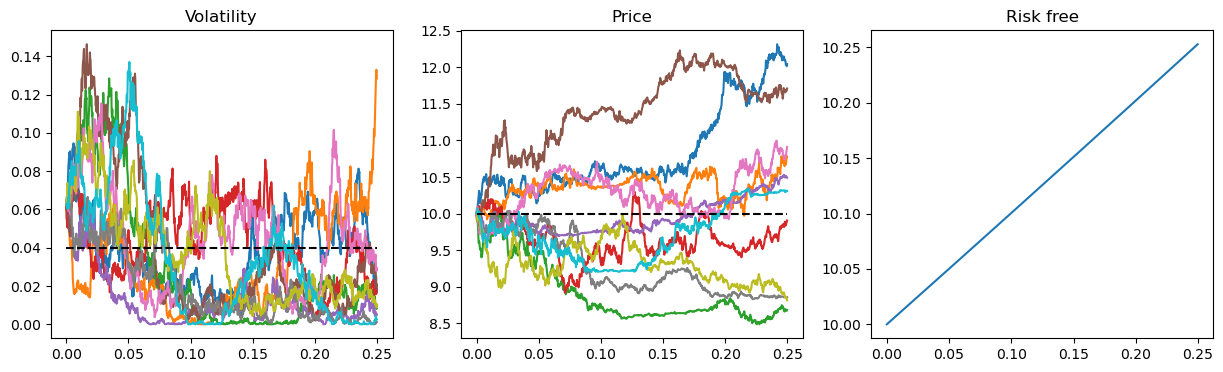

In [6]:
dt = T/N

brownian = np.random.multivariate_normal(
    [0,0], 
    [[1, rho],[rho,1]], 
    size=(M,N)
)
dW, dW_hat= brownian[:,:,0]*np.sqrt(dt), brownian[:,:,1]*np.sqrt(dt)


@njit()
def generate_trajectories(dW, dW_hat, kappa, theta, v0, S0, eta, dt,r, N):
    v = np.zeros_like(dW_hat)
    S = np.zeros_like(v)
    v[:,0] = v0
    S[:, 0] = S0

    for t in range(1,N):
        v[:, t] = v[:, t-1] + kappa * (theta - v[:, t-1]) * dt + eta * np.sqrt(np.maximum(v[:, t-1], 0)) * dW[:, t-1]
        
        # Ensure the volatility remains non-negative
        v[:, t] = np.maximum(v[:, t], 0)
        
        # Update price path using the Heston price process
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * v[:, t-1]) * dt + np.sqrt(v[:, t-1]) * dW_hat[:, t-1])
        

    return S, v

St, vt = generate_trajectories(dW, dW_hat, kappa, theta, v0, S0, eta, dt,r, N)
fig, ax = plt.subplots(1,3, figsize = (15,4))

t = np.arange(0,T, dt)
ax[0].plot(t, vt[0:10].T)
ax[0].set_title("Volatility")
ax[0].hlines(theta, 0, T, linestyles = 'dashed', color = 'black')
ax[1].plot(t, St[0:10].T)
ax[1].set_title("Price")
ax[1].hlines(S0, 0, T, linestyles = 'dashed', color = 'black')

ax[2].plot(t, S0* np.exp(r*t).T)
ax[2].set_title("Risk free")

In [7]:
g = lambda s, K: np.maximum(K - s, 0)

In [8]:
params = {
    'kappa': 5.0,
    'K': 10,
    'r': 0.1,
    'eta': 0.9 ,
    'theta': 0.16,
    'rho': 0.1,
    'T' : 0.25,
    'v0' : 0.25**2,
    'S0' : 10,
    'N': 500, 
    'M': 1000
}

params['h'] = params['T']/params['N']
params['x0'] = np.log(params['S0'])
params['y0'] = params['v0']/params['eta'] - params['rho'] * params['x0']
params['A'] = (params['kappa']*params['theta']/params['eta'] - np.abs(params['rho'])*params['r'])*np.sqrt(params['h']/(params['eta']*(1-params['rho']**2)))

kappa = 5.0
K = 10
r = 0.1
eta = 0.9
theta = 0.16
rho = 0.1
T = 0.25
v0 = 0.25**2
S0 = 10
N = 200
M = 1000
dt = T/N

In [9]:
brownian = np.random.multivariate_normal(
    [0,0], 
    [[1, rho],[rho,1]], 
    size=(M,N)
)
dW, dW_hat= brownian[:,:,0]*np.sqrt(dt), brownian[:,:,1]*np.sqrt(dt)
St, vt = generate_trajectories(dW, dW_hat, kappa, theta, v0, S0, eta, dt,r, N)

In [10]:
def get_variance(St, vt):
    quantiles = np.linspace(0,1,t+3)

    variances = pd.Series(vt[:, t], name = 'variance')
    prices_t = pd.Series(St[:, t], name = 'prices')
    price_var = pd.concat([variances, prices_t], axis = 1)

    price_var['quantile'] = pd.qcut(price_var['prices'], quantiles)
    
    return price_var.groupby('quantile')\
        .mean()\
        .variance\
        .iloc[1:]\
        .to_numpy()\
        .reshape(-1,1)

In [31]:
M 

1000

In [139]:
# N = 500
n = 100
M = 10000
dt = T/n
S0 = 10

option_prices = []


memo = {}
brownian = np.random.multivariate_normal(
    [0,0], 
    [[1, rho],[rho,1]], 
    size=(M,n)
)
dW, dW_hat= brownian[:,:,0]*np.sqrt(dt), brownian[:,:,1]*np.sqrt(dt)
St, vt = generate_trajectories(dW, dW_hat, kappa, theta, v0, S0, eta, dt,r, n)

for t in tqdm(range(n-1, -1, -1)):
    
    prices = possible_prices(St, t)
    if t == 0:
        var = v0
    
    else:
        var = get_variance(St, vt)

    var = np.mean(vt[:,t])

    # var = np.mean(vt[:,t])
    log_prices = np.log(prices)

    memo[t] = np.zeros_like(prices)
    stopping_values = g(prices, K)

    if t == n-1:
        memo[t] = stopping_values
        continue

    future_prices = possible_prices(St, t+1)
    log_future_prices = np.log(future_prices)
    
    log_future_prices[0:-1] += np.diff(log_future_prices)/2

    # log_future_prices[-1] = log_future_prices[-1] - (log_future_prices[-1] - log_future_prices[-2])/2
    # probabilities[i][j] = proba(S_{t+1} in (possible_prices[j], possible_prices[j+1]) | S_t = possible_prices[i])
    probabilities = np.zeros((t+1, t+2))
    matrix = np.tile(log_prices.reshape(t+1, 1), (1, t + 2))

    cdf_values = norm.cdf((log_future_prices-matrix- (r-var/2)*dt)/np.sqrt(dt*var))

    
    probabilities[:, 1:] = np.diff(cdf_values, axis = 1)
    probabilities[:, -1] = 1-cdf_values[:, -1]  
    probabilities[:, 0] = cdf_values[:,0]
    
    # probabilities[(np.isnan(probabilities))] = 1e-50

    # for i, log_price in enumerate(log_prices):

    #     cdf_values = norm.cdf((log_future_prices - log_price - (r - var / 2) * dt) / np.sqrt(var * dt))
        
    #     # Compute the transition probabilities between intervals
    #     probabilities[i, 1:] = np.diff(cdf_values)
    #     probabilities[i, 0] =  cdf_values[0]
    #     probabilities[i, 1:] = np.maximum(np.diff(cdf_values), 1e-50)  # Use max to avoid zeros

    #     probabilities[i, 0] = max(cdf_values[0], 1e-50) 
    # break
    if (probabilities.sum(axis = 1) == 0).any():
        break
    
    probabilities = probabilities / probabilities.sum(axis = 1, keepdims = True)
    # if n == 12:
    #     break

    continuation_values = probabilities @ (memo[t+1]*np.exp(-r*dt))

    # memo[t]= continuation_values
    memo[t]= np.maximum(continuation_values, stopping_values)

option_prices.append(memo[0])
print(memo[0])

100%|██████████| 100/100 [00:01<00:00, 68.49it/s]

[0.5358464]


## Computing probabilities from empirical values

In [137]:
# N = 500
n = 500
M = n*100

option_prices = []
dt = T/n
S0 = 8

memo = {}
brownian = np.random.multivariate_normal(
    [0,0], 
    [[1, rho],[rho,1]], 
    size=(M,n)
)
dW, dW_hat= brownian[:,:,0]*np.sqrt(dt), brownian[:,:,1]*np.sqrt(dt)
St, vt = generate_trajectories(dW, dW_hat, kappa, theta, v0, S0, eta, dt,r, n)

for t in tqdm(range(n-1, -1, -1)):
    memo[t] = np.zeros(t)


    quantiles = np.linspace(0,1,t+2)

    variances = pd.Series(vt[:, t], name = 'variance_i')
    prices_t = pd.Series(St[:, t], name = 'prices_i')
    price_var = pd.concat([variances, prices_t], axis = 1)

    price_var['q_i'] = pd.qcut(price_var['prices_i'], quantiles, labels=False)

    stopping_values = g(possible_prices(St, t), K)
    if t == n-1:
        memo[t] = stopping_values
        continue

    q_next = np.linspace(0,1,t+3)

    variances = pd.Series(vt[:, t+1], name = 'variance_i+1')
    prices_t = pd.Series(St[:, t+1], name = 'prices_i+1')
    price_var_next = pd.concat([variances, prices_t], axis = 1)

    price_var_next['q_i+1'] = pd.qcut(price_var_next['prices_i+1'], q_next, labels=False)


    df = pd.concat([price_var, price_var_next], axis=1)

    transitions = df.groupby(['q_i', 'q_i+1'])\
        .size()\
        .unstack(fill_value=0)\
        .to_numpy()
    
    probabilities = transitions/transitions.sum(axis = 1, keepdims = True)

    
    #     break

    continuation_values = probabilities @ (memo[t+1]*np.exp(-r*dt))

    # memo[t]= continuation_values
    memo[t]= np.maximum(continuation_values, stopping_values)

option_prices.append(memo[0])
print(memo[0])

100%|██████████| 500/500 [00:36<00:00, 13.83it/s]

[2.]
